### Visualization: Carries
<h5>Notebook Brief:</h5>

In this notebook, I attempt to visualize the distance distribution when players carry the ball progressively. So, what is carry and where should it be considered as a progressive one? 

A progressive carry is any carry that moves the ball at least five metres towards the opposing goal.
<h5>Workflow (Steps):</h5>

><ol>
     Extract events data from StatsBomb API 
    <li> Filter data to find ball carriers </li>
    <li> For each carrier, plot the carries distribution by distance </li>
    <li> Plot Saka's carries in the attacking half </li>
    <li> Plot players carries in the pitch </li>
 </ol>

Imports

In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np

import seaborn as sn 
import matplotlib.pyplot as plt
from mplsoccer import Pitch, FontManager, VerticalPitch

import warnings
warnings.filterwarnings('ignore')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab%5Bwght%5D.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto-Italic%5Bwdth,wght%5D.ttf')

1. Extract events data from StatsBomb API

In [2]:
df_comps=  sb.competitions()

# Get competition and season ids 
df_comps[(df_comps.competition_name== 'FIFA World Cup') & (df_comps.season_name== '2022')]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
18,43,106,International,FIFA World Cup,male,False,True,2022,2023-02-01T03:43:28.823950,2023-01-26T11:23:27.631134,2023-01-26T11:23:27.631134,2023-02-01T03:43:28.823950


In [3]:
grouped_events = sb.competition_events(
    country="International",
    division= "FIFA World Cup",
    season="2022",
    split=True
)


In [4]:
carries_df= grouped_events["carrys"]
carries_df.head(2)

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,player,position,location,duration,related_events,match_id,carry_end_location,possession_team_id,player_id,under_pressure
0,bc9baa19-8776-422c-9dff-74f487d32151,7,1,00:00:02.174,0,2,Carry,2,Switzerland,From Kick Off,...,Manuel Obafemi Akanji,Right Center Back,"[35.0, 55.6]",2.064205,"[7bd6d8a9-4ab4-49da-a34c-a0bc30c59d8d, a376b96...",3869254,"[36.3, 56.9]",773,5549,NaN
1,23e55c08-2270-4436-967d-1cbc7bce69e4,16,1,00:00:13.234,0,13,Carry,3,Portugal,Regular Play,...,José Diogo Dalot Teixeira,Right Back,"[39.6, 66.6]",1.346166,"[627fd8cd-aec3-4e95-8a70-f1832a4d7e7f, 83b987a...",3869254,"[42.2, 74.3]",780,16028,True


In [5]:
carries_df= carries_df[["possession_team", "player_id", "player", "location", "carry_end_location"]]
carries_df.head()

,possession_team,player_id,player,location,carry_end_location
0,Switzerland,5549,Manuel Obafemi Akanji,"[35.0, 55.6]","[36.3, 56.9]"
1,Portugal,16028,José Diogo Dalot Teixeira,"[39.6, 66.6]","[42.2, 74.3]"
2,Portugal,3193,Bernardo Mota Veiga de Carvalho e Silva,"[69.5, 22.5]","[69.5, 22.2]"
3,Portugal,12041,João Félix Sequeira,"[69.1, 15.3]","[69.4, 15.6]"
4,Portugal,11184,Otávio Edmilson da Silva Monteiro,"[50.1, 19.0]","[47.0, 13.5]"


2. Filter data to find ball carriers

In [6]:
# Split location column into start_X and start_Y columns
carries_df[['start_X', 'start_Y']] = pd.DataFrame(carries_df['location'].to_list(), index= carries_df.index)
carries_df[['end_X', 'end_Y']]= pd.DataFrame(carries_df['carry_end_location'].to_list(), index= carries_df.index)
carries_df.drop(['location', 'carry_end_location'], axis=1, inplace= True)

# Add distance column
carries_df['distance']= np.sqrt((carries_df.start_X - carries_df.end_X)**2 + (carries_df.start_Y - carries_df.end_Y)**2)

# Add columns start & end that decribes how far from the goak the start or the end was 
pitch_width= 120
pitch_height= 40 
carries_df['start']= np.sqrt((pitch_width - carries_df.start_X)**2 + (pitch_height - carries_df.start_Y)**2)
carries_df['end']= np.sqrt((pitch_width - carries_df.end_X)**2 + (pitch_height - carries_df.end_Y)**2)

# Add isProgressive column
carries_df['isProgressive']= [(carries_df.end[i] - carries_df.start[i]) >10 for i in range(len(carries_df))]

In [7]:
# save data
carries_df.to_parquet('../Data/carries.parquet')

In [8]:
# Merge data
top_carriers = carries_df.groupby('player_id')["distance"].sum().sort_values(ascending=False).reset_index()
top_carriers= top_carriers.merge(carries_df[['player_id', 'player']].drop_duplicates(), on='player_id')[:12]

In [9]:
top_carriers

,player_id,distance,player
0,6765,3219.192608,Rodrigo Hernández Cascante
1,5503,2885.864191,Lionel Andrés Messi Cuccittini
2,5463,2752.482807,Luka Modrić
3,3244,2580.419598,John Stones
4,33018,2490.402918,Joško Gvardiol
5,3090,2488.293769,Nicolás Hernán Otamendi
6,3009,2482.791516,Kylian Mbappé Lottin
7,5456,2406.576457,Mateo Kovačić
8,5469,2302.596095,Marcelo Brozović
9,7797,2302.087409,Rodrigo Javier De Paul


3. For each carrier, plot the carries distribution by distance

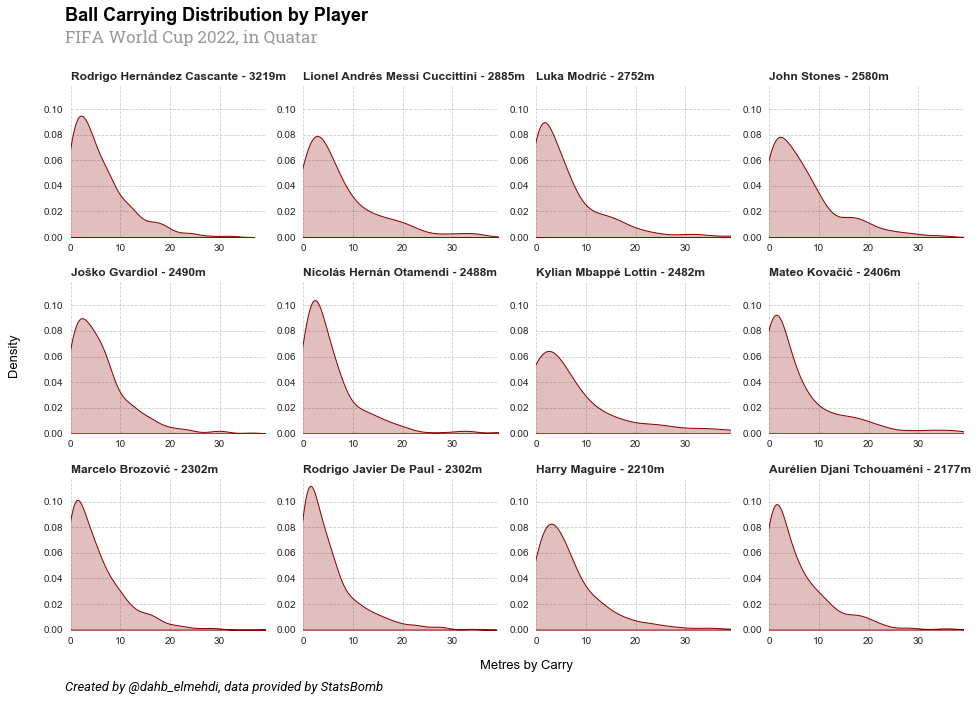

In [10]:
# Set Kde plot style
sn.set_style("ticks",{'axes.grid' : True, 'grid.linestyle':'--'})

# Set Figure 
fig, ax = plt.subplots(3, 4, figsize=(16, 10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3) 
ax = ax.ravel()

# Plot KDE distribution by axis
top_12_players = top_carriers[:12].player.tolist()
for i, player in enumerate(top_12_players):
    carrier = carries_df.loc[carries_df.player == player]
    sn.kdeplot(data= carrier.distance, shade=True, ax=ax[i], color='#8B0000')
    ax[i].set_xlim(left=0)
    ax[i].tick_params(left=False, bottom=False, labelbottom=True, labelleft=True)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    sn.despine(bottom=True, left=True, ax=ax[i])
    ax[i].set_title('{0} - {1}m'.format(player, int(carrier.distance.sum())), fontweight='bold', loc='left')

# Set titles and description
title_text= "Ball Carrying Distribution by Player "
subtitle= "FIFA World Cup 2022, in Quatar"
y_label= 'Density'
x_label= 'Metres by Carry'
Description= 'Created by @dahb_elmehdi, data provided by StatsBomb'

# plot titles and description
fig.text(0.12, .97, title_text, fontsize=18, fontweight= 'bold', color='black')
fig.text(0.12, .94, subtitle, fontsize=17, color='black',fontproperties= font_bold.prop,alpha=.4)
fig.text(0.12, .04, Description, fontsize=13, color='black',fontproperties= font_italic.prop)
fig.text(0.48, 0.07, x_label, fontsize=13, color='black')
fig.text(0.07, 0.48, y_label, fontsize=13, color='black', rotation= 90)

plt.show()

In [11]:
# save plot
fig.savefig("../Plots/carries-1.png", dpi= 150, bbox_inches='tight')

4. Plot Saka's carries ending in First-Half

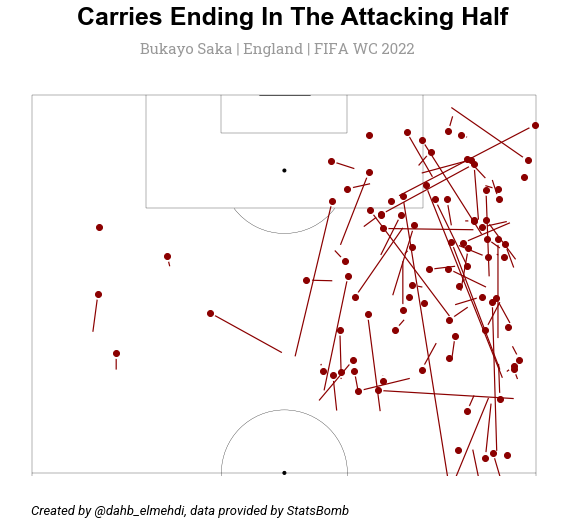

In [12]:
carries= carries_df[carries_df['player']== 'Bukayo Saka']

# Set pitch
pitch = VerticalPitch(pitch_type= 'statsbomb',pad_bottom=0.5, half= True, goal_alpha=1,
                      pitch_color= 'white', line_color='black', linewidth=.3) 
fig, ax = pitch.draw(figsize=(8, 8))


# Plot carries  
pitch.scatter(carries.end_X, carries.end_Y,color="#8B0000", ax=ax)
pitch.arrows(carries.start_X, carries.start_Y,
            carries.end_X, carries.end_Y, color = "#8B0000", ax=ax, width=1.2, headwidth= 0)

# Set titles 
title_text= "Carries Ending In The Attacking Half "
subtitle= "Bukayo Saka | England | FIFA WC 2022"

# Add titles
fig.text(0.14, .93, title_text, fontsize=25, fontweight= 'bold', color='black')
fig.text(0.25, .88, subtitle, fontsize=15, color='black',fontproperties= font_bold.prop,alpha=.4)
fig.text(0.06, .08, Description, fontsize=13, color='black',fontproperties= font_italic.prop)

# save plot
fig.savefig("../Plots/carries-2.png", dpi= 150, bbox_inches='tight')

5. Plot players carries in the pitch

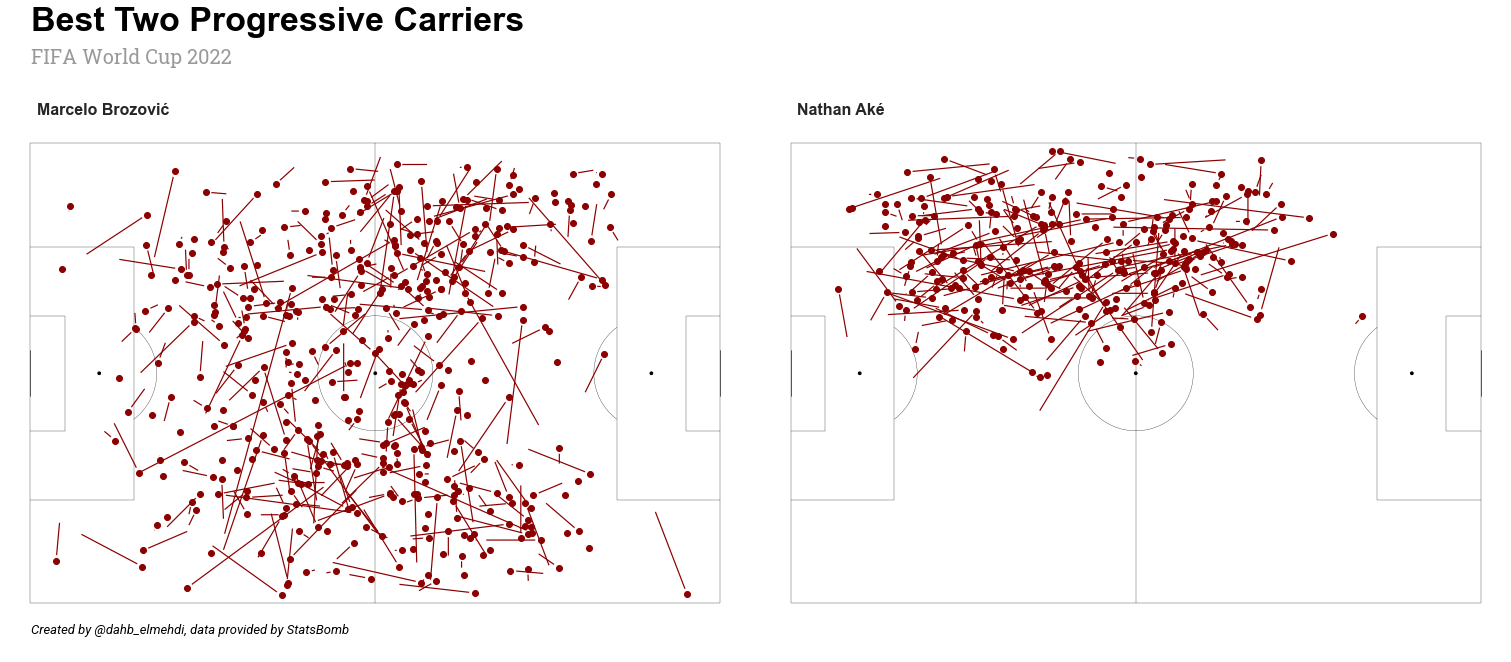

In [13]:
# Merge data
top_carriers = carries_df.loc[carries_df.isProgressive== True].groupby('player_id')["distance"].sum().sort_values(ascending=False).reset_index()[:2]
top_carriers= top_carriers.merge(carries_df.drop_duplicates(), on='player_id')

# Set pitches
pitch = Pitch(pitch_type= 'statsbomb',pad_bottom=0.5, goal_alpha=1,
                      pitch_color= 'white', line_color='black', linewidth=.3) 
fig, ax= pitch.grid(ncols= 2, grid_height= .75, space= .05, axis= False)

players= list(top_carriers.player.unique())

for index, player in enumerate(players):
    df= top_carriers.loc[top_carriers.player== player]
    ax['pitch'][index].set_title(label=f"{player}", loc='left',x= .04, fontweight='bold', fontsize= 16)
    ax['pitch'][index].scatter(df.end_X, df.end_Y,color="#8B0000")
    pitch.arrows(df.start_X, df.start_Y,df.end_X, df.end_Y, color = "#8B0000", width=1.2, headwidth= 0, ax=ax['pitch'][index])

# Set titles
title_text= "Best Two Progressive Carriers"
subtitle= "FIFA World Cup 2022"

# Add titles
fig.text(0.04, .97, title_text, fontsize=34, fontweight= 'bold', color='black')
fig.text(0.04, .92, subtitle, fontsize=20, color='black',fontproperties= font_bold.prop,alpha=.4)
fig.text(0.04, .04, Description, fontsize=13, color='black',fontproperties= font_italic.prop)

# Save the graph
fig.savefig("../Plots/carries-3.png", dpi= 150, bbox_inches='tight')

We may conclude from a simple interpretation of the graph that Brozovic and Nathan Aké are at similar levels in terms of ball advancement. Despite the fact that Brozovic is a high volume carrier.
